<a href="https://colab.research.google.com/github/ShreyaRuhela/Medical-disease-detection-with-Xai/blob/main/Pneumonia_detection_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import os

### Data Augmentation

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # <-- This is the key!
)

# The test generator only needs to be rescaled
test_datagen = ImageDataGenerator(rescale=1./255)

### Data loading

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# 2. Define your directories
train_dir = '/content/drive/MyDrive/chest_xray/chest_xray/train'
test_dir = '/content/drive/MyDrive/chest_xray/chest_xray/train'
# We will NOT use the 'val' directory

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32


In [21]:
# 3. Create the generators from the directories
#    This will create an augmented training set
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',       # <-- Use the 'training' subset
    color_mode='grayscale'   # <-- Match your model's input
)
val_gen = train_datagen.flow_from_directory(
    train_dir,                 # <-- Point to the SAME directory
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',     # <-- Use the 'validation' subset
    color_mode='grayscale'
)

# This is your final, non-augmented test set
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [22]:
# using namespace std;

print(f"Total images in the Training set:   {train_gen.samples}")
print(f"Total images in the Validation set: {val_gen.samples}")
print(f"Total images in the Test set:       {test_gen.samples}")

Total images in the Training set:   4173
Total images in the Validation set: 1043
Total images in the Test set:       5216


Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


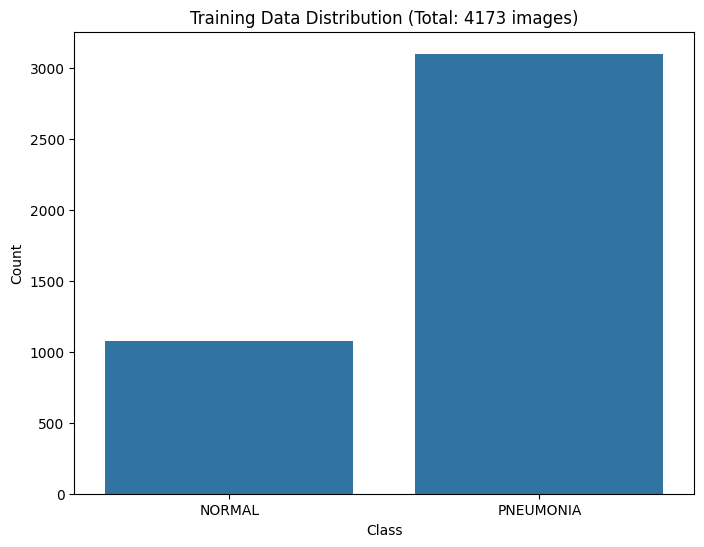

In [26]:
import seaborn as sns
import pandas as pd

# 'train_gen' should be your *final* generator (e.g., the ResNet one)
print(f"Class mapping: {train_gen.class_indices}")

# Get the list of all class names
class_names = [list(train_gen.class_indices.keys())[i] for i in train_gen.classes]

# Plot the count
plt.figure(figsize=(8, 6))
sns.countplot(x=class_names)
plt.title(f"Training Data Distribution (Total: {len(class_names)} images)")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()

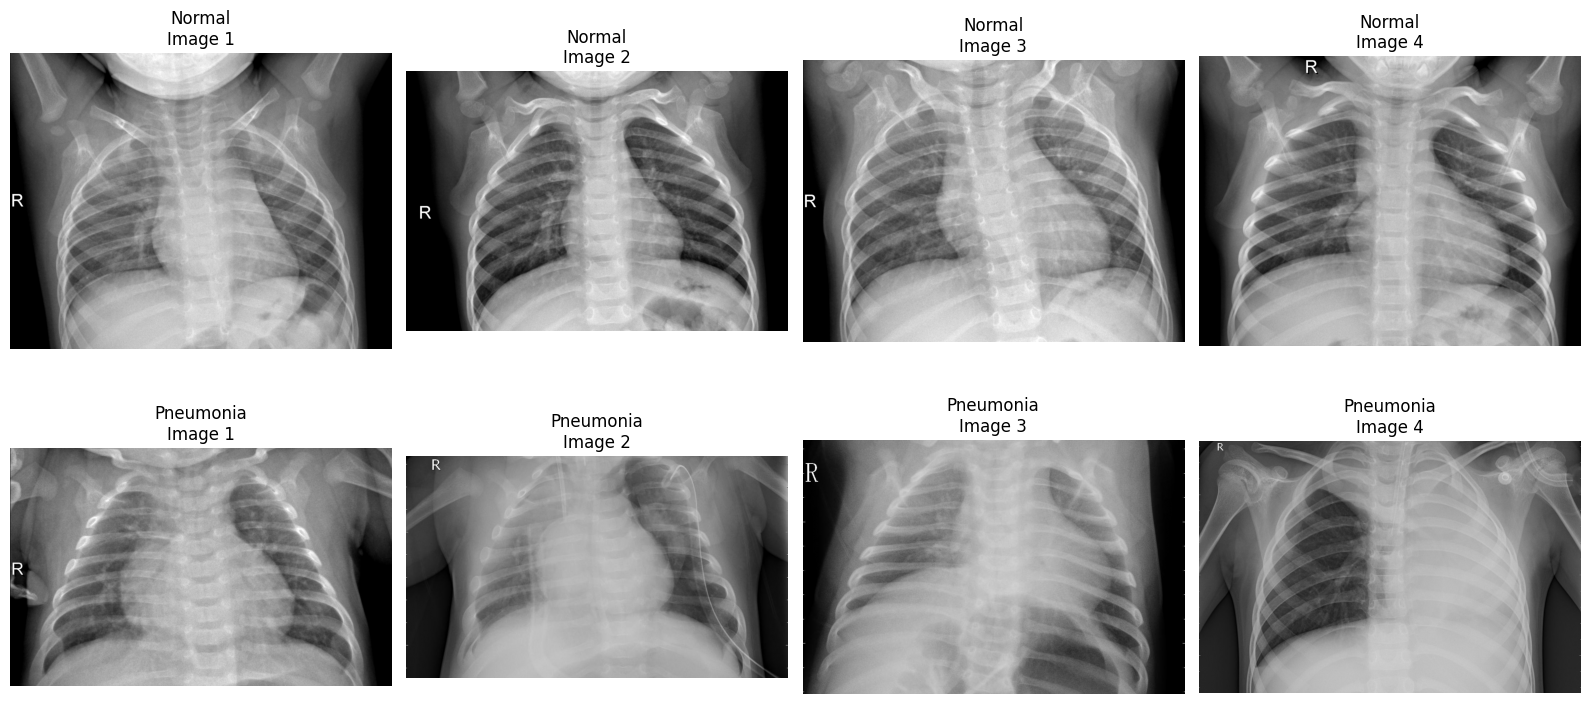

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# --- 1. Define your data directories ---
# Make sure this path is correct
train_dir = '/content/drive/MyDrive/chest_xray/chest_xray/train'

# Define paths to the subfolders
normal_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# --- 2. Get the first 4 image filenames from each class ---
try:
    normal_images = os.listdir(normal_dir)[:4]
    pneumonia_images = os.listdir(pneumonia_dir)[:4]
except FileNotFoundError:
    print(f"Error: Directory not found. Please check your 'train_dir' path.")
    print(f"Path I tried to use: {train_dir}")
    # Stop here if the path is wrong
    raise

# --- 3. Create the 2x4 plot ---
plt.figure(figsize=(16, 8)) # You can adjust the size

# Plot the 'NORMAL' images
for i, img_name in enumerate(normal_images):
    # Create the full path to the image
    img_path = os.path.join(normal_dir, img_name)
    # Read the image
    img = mpimg.imread(img_path)

    # Create a subplot (2 rows, 4 columns, i+1 position)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Normal\nImage {i+1}")
    plt.axis('off') # Hide the axes

# Plot the 'PNEUMONIA' images
for i, img_name in enumerate(pneumonia_images):
    # Create the full path to the image
    img_path = os.path.join(pneumonia_dir, img_name)
    # Read the image
    img = mpimg.imread(img_path)

    # Create a subplot (2 rows, 4 columns, i+5 position to move to 2nd row)
    plt.subplot(2, 4, i + 5)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pneumonia\nImage {i+1}")
    plt.axis('off') # Hide the axes

plt.tight_layout() # Prevents titles from overlapping
plt.show()

Augmented Images

Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


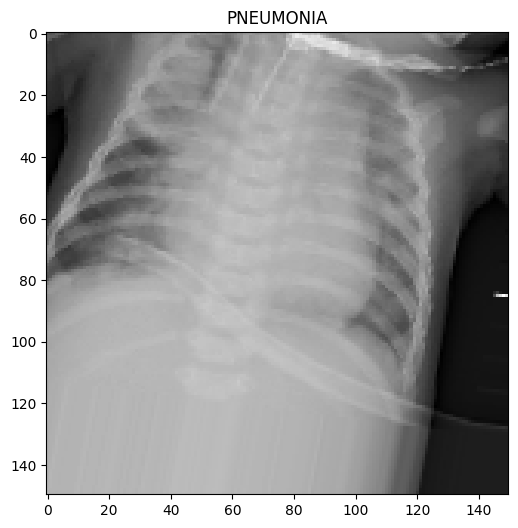

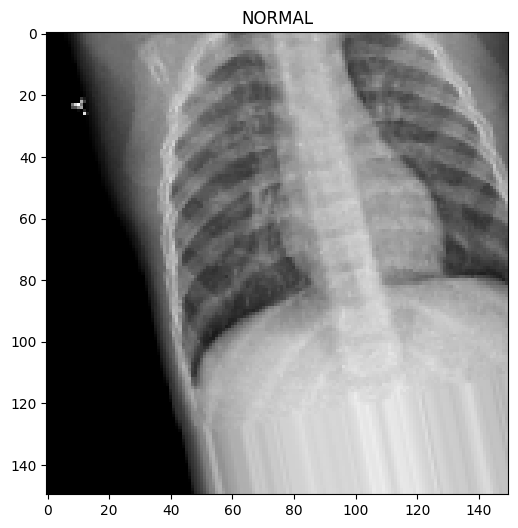

In [24]:
label_map = train_gen.class_indices
print(f"Class mapping: {label_map}")

# 2. Create the list of labels in the *correct order*
#    This creates ['NORMAL', 'PNEUMONIA']
labels_list = list(label_map.keys())

# 3. Get one batch of data from the generator
#    images_batch will be (Batch_Size, 150, 150, 1)
#    labels_batch will be (Batch_Size,)
images_batch, labels_batch = next(train_gen)

# --- Now we can plot images from this batch ---

# 4. Plot the first image in that batch
plt.figure(figsize=(6,6))
# images_batch[0] is the first image
# .squeeze() removes the (1) color channel for plotting
plt.imshow(images_batch[0].squeeze(), cmap='gray')

# labels_batch[0] is the label (e.g., 0.0 or 1.0)
# We convert it to an integer to use as an index
image_label_index = int(labels_batch[0])
plt.title(labels_list[image_label_index])
plt.show()

# 5. Plot the second image in that batch
plt.figure(figsize=(6,6))
plt.imshow(images_batch[1].squeeze(), cmap='gray')
image_label_index = int(labels_batch[1])
plt.title(labels_list[image_label_index])
plt.show()

In [9]:
#Normalize the data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # <-- THIS LINE IS DOING THE NORMALIZATION
    rotation_range=20,
    # ...other augmentations
)

### **VGG16**

In [13]:
#VGG 16
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input # <-- VGG16's function
from sklearn.utils.class_weight import compute_class_weight

# 1. Define Image Size for VGG16
# VGG16 can use 150x150, but 224x224 is standard. Let's use 150x150
# to match your original model's input size.
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# 2. Define your directories (Corrected test_dir)
train_dir = '/content/drive/MyDrive/chest_xray/chest_xray/train'
test_dir = '/content/drive/MyDrive/chest_xray/chest_xray/test' # <-- Corrected path

# 3. Use VGG16's specific preprocessing
#    We REMOVE rescale=1./255
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <-- Use VGG16's function
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Test generator ONLY uses the preprocessing function
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # <-- Use VGG16's function
)

# 4. Create generators (MUST be color_mode='rgb')
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    color_mode='rgb'                # <-- VGG16 requires 3 channels
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    color_mode='rgb'                # <-- VGG16 requires 3 channels
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'                # <-- VGG16 requires 3 channels
)

# 5. Calculate Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


In [11]:
"""import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# 1. Load the VGG16 base model
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150, 150, 3))

# 2. Freeze the base model
base_model.trainable = False

# 3. Create your new Sequential model
model = Sequential()

# 4. Add the frozen VGG16 base
model.add(base_model)

# 5. Add your own classifier on top
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# 6. Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True  # <-- ADD THIS LINE HERE
             )

# 7. Print the summary
print("--- VGG16 Model Summary ---")
model.summary() """

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- VGG16 Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Original VGG16 Code

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

print("Callback 'learning_rate_reduction' is now defined.")
history_vgg16 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[learning_rate_reduction],
    class_weight=class_weights
    # No 'run_eagerly' argument here
)

# --- Save your model ---
model.save("vgg16_model.h5")
print("\n--- VGG16 MODEL SAVED TO FILE (vgg16_model.h5) ---")

Callback 'learning_rate_reduction' is now defined.
Epoch 1/10


KeyboardInterrupt: 

Fine tune code for X-ai

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# --- Define Model ---
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150, 150, 3))
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# --- Compile Model ---
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True
             )

# --- Define Callback ---
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

# --- Train and Save Model ---
history_vgg16 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[learning_rate_reduction],
    class_weight=class_weights
)

model.save("vgg16_model.h5")
print("\n--- VGG16 MODEL SAVED TO FILE (vgg16_model.h5) ---")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 56/131 ━━━━━━━━━━━━━━━━━━━━ 44:16 35s/step - accuracy: 0.7348 - loss: 1.9001

KeyboardInterrupt: 

**Test accuracy and Loss for VGG16**

In [ ]:
print("Evaluating the VGG16 model on the unseen test data...")

# model.evaluate() will run through all the images in your test_gen
# and return the loss and accuracy.
results = model.evaluate(test_gen)

print("\n--- Final Test Results ---")
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

### **RESNET50**

In [39]:
#RESNET
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input # <-- ResNet's function
from sklearn.utils.class_weight import compute_class_weight

# 1. Define Image Size for ResNet50
IMAGE_SIZE = (224, 224) # <-- ResNet uses 224x224
BATCH_SIZE = 32

# 2. Define your directories
train_dir = '/content/drive/MyDrive/chest_xray/chest_xray/train'
test_dir = '/content/drive/MyDrive/chest_xray/chest_xray/test'

# 3. Use ResNet's specific preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <-- Use ResNet's function
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Test generator ONLY uses the preprocessing function
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # <-- Use ResNet's function
)

# 4. Create generators (MUST be color_mode='rgb')
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,         # <-- Updated to 224x224
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    color_mode='rgb'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,         # <-- Updated to 224x224
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    color_mode='rgb'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,         # <-- Updated to 224x224
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

# 5. Calculate Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# 1. Load the ResNet50 base model
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3)) # Match your IMAGE_SIZE

# 2. Freeze the base model
base_model.trainable = False

# 3. Add your custom classifier on top
# We use a functional API approach, which is common with ResNet
x = base_model.output
x = GlobalAveragePooling2D()(x) # <-- Use this instead of Flatten
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(units=1, activation='sigmoid')(x) # Your final output layer

# 4. Create the new model
model = Model(inputs=base_model.input, outputs=output)

# 5. Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), # 0.0001
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 6. Print the summary
print("--- ResNet50 Model Summary ---")
model.summary()

--- ResNet50 Model Summary ---


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
# Define the learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)
print("Callback defined.")

Callback defined.


In [22]:
history_resnet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[learning_rate_reduction],
    class_weight=class_weights
)
# --- Save the model to a file ---
# This is the robust way to fix your XAI errors
model.save("resnet_model.h5")
print("Model saved to resnet_model.h5")

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 981ms/step - accuracy: 0.8437 - loss: 0.3683 - val_accuracy: 0.9032 - val_loss: 0.2468 - learning_rate: 1.0000e-04
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 117s 895ms/step - accuracy: 0.9112 - loss: 0.2122 - val_accuracy: 0.9319 - val_loss: 0.1684 - learning_rate: 1.0000e-04
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 893ms/step - accuracy: 0.9350 - loss: 0.1693 - val_accuracy: 0.9367 - val_loss: 0.1615 - learning_rate: 1.0000e-04
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 116s 884ms/step - accuracy: 0.9432 - loss: 0.1433 - val_accuracy: 0.9319 - val_loss: 0.1735 - learning_rate: 1.0000e-04
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 116s 887ms/step - accuracy: 0.9475 - loss: 0.1287 - val_accuracy: 0.9377 - val_loss: 0.1460 - learning_rate: 1.0000e-04
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 117s 891ms/step - accuracy: 0.9483 - loss: 0.1206 - val_accuracy: 0.9569 - val_loss: 0.1273 - learning_rate: 1.0000e-04
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 

Model saved to resnet_model.h5


## **Test accuracy and Loss for** **Resnet50**

In [47]:
print("Evaluating the ResNet50 model on the unseen test data...")

# model.evaluate() will predict on all batches in your test_gen
# and return the final loss and accuracy.
results = model.evaluate(test_gen)

print("\n--- Final Test Results (ResNet50) ---")
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

Evaluating the ResNet50 model on the unseen test data...
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step - accuracy: 0.8439 - loss: 0.4283

--- Final Test Results (ResNet50) ---
Test Loss: 0.3222629129886627
Test Accuracy: 0.879807710647583


In [24]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """
    Plots the training & validation accuracy and loss for a given model.
    """
    print(f"--- Plotting results for {model_name} ---")

    # 1. Get the lists of results
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # 2. Get the number of epochs
    epochs_range = range(1, len(train_acc) + 1)

    # 3. Create the plots
    plt.figure(figsize=(20, 8))

    # --- Plot 1: Accuracy ---
    plt.subplot(1, 2, 1) # 1 row, 2 cols, plot 1
    plt.plot(epochs_range, train_acc, 'go-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} - Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # --- Plot 2: Loss ---
    plt.subplot(1, 2, 2) # 1 row, 2 cols, plot 2
    plt.plot(epochs_range, train_loss, 'g-o', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'r-o', label='Validation Loss')
    plt.title(f'{model_name} - Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Validation plots

In [3]:
# Plot the VGG16 results
plot_history(history_vgg16, "VGG16")

# Plot the ResNet50 results
plot_history(history_resnet, "ResNet50")

NameError: name 'plot_history' is not defined

In [27]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# We are using the 'model' that is already trained and in memory.
# Or, for 100% safety, you can load it from the file:
# from tensorflow.keras.models import load_model
# model = load_model("resnet_model.h5")

print("--- Setting up for Fine-Tuning ---")

# 1. Un-freeze the base model layers
# This allows the pre-trained weights to be updated
model.trainable = True

print("All model layers have been un-frozen.")

# 2. Re-compile the model with a VERY low learning rate
# This is the most important part of fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5), # 0.00001 (10x smaller than before)
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model re-compiled with a tiny learning rate for fine-tuning.")

--- Setting up for Fine-Tuning ---
All model layers have been un-frozen.
Model re-compiled with a tiny learning rate for fine-tuning.


In [28]:
print("--- Starting Fine-Tuning ---")

# We'll train for a few more epochs to adapt the new layers
fine_tune_epochs = 5

# Get the last epoch number (e.g., if you trained for 10, this is 9)
last_epoch = history_resnet.epoch[-1]

# Calculate the total number of epochs to run until
total_epochs = last_epoch + 1 + fine_tune_epochs

# Continue training
history_fine_tune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=total_epochs,
    initial_epoch=last_epoch + 1, # Start from the epoch *after* you finished
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[learning_rate_reduction], # Your same callback
    class_weight=class_weights
)

# --- Save your new, fine-tuned model ---
model.save("resnet_model_finetuned.h5")
print("\n--- Fine-Tuned Model Saved to resnet_model_finetuned.h5 ---")

--- Starting Fine-Tuning ---
Epoch 11/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 136s 964ms/step - accuracy: 0.9607 - loss: 0.0991 - val_accuracy: 0.9559 - val_loss: 0.1150 - learning_rate: 1.0000e-05
Epoch 12/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 116s 890ms/step - accuracy: 0.9553 - loss: 0.1067 - val_accuracy: 0.9492 - val_loss: 0.1183 - learning_rate: 1.0000e-05
Epoch 13/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 117s 896ms/step - accuracy: 0.9598 - loss: 0.1035 - val_accuracy: 0.9588 - val_loss: 0.1180 - learning_rate: 1.0000e-05
Epoch 14/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 117s 892ms/step - accuracy: 0.9680 - loss: 0.0981 - val_accuracy: 0.9530 - val_loss: 0.1186 - learning_rate: 1.0000e-05
Epoch 15/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.9645 - loss: 0.0994
Epoch 15: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
131/131 ━━━━━━━━━━━━━━━━━━━━ 116s 886ms/step - accuracy: 0.9645 - loss: 0.0993 - val_accuracy: 0.9501 - val_loss: 0.1199 - learning_rate: 1.0000e-05



--- Fine-Tuned Model Saved to resnet_model_finetuned.h5 ---


## Grad Cam on resnet

--- Starting XAI Grad-CAM Analysis (v2) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Trained model 'resnet_model.h5' loaded successfully.
Found the last Conv2D layer: conv5_block3_3_conv
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 524ms/step
Analyzing a correct PNEUMONIA prediction (index 235)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_4']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Heatmap generated successfully.


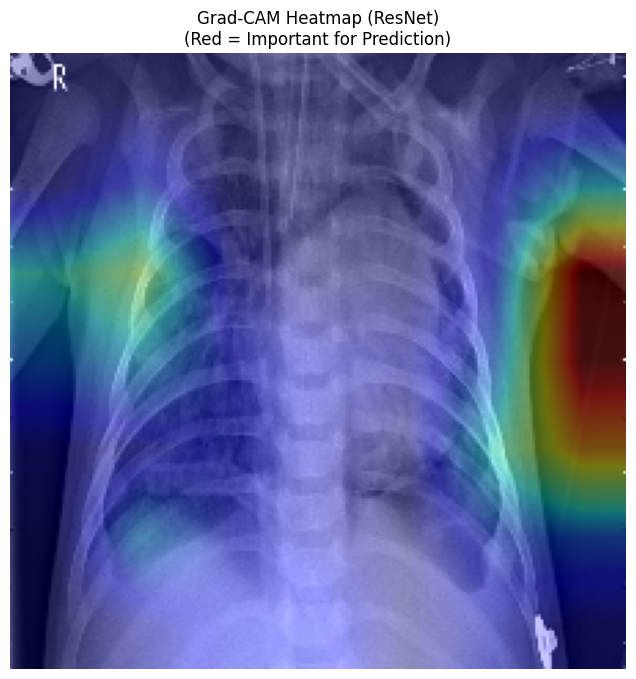

In [41]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.cm as cm
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

print("--- Starting XAI Grad-CAM Analysis (v2) ---")

try:
    # --- Load the saved, trained model ---
    model = load_model("resnet_model.h5")
    print("Trained model 'resnet_model.h5' loaded successfully.")

    # --- XAI Step 1: Find Last Conv Layer ---
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            last_conv_layer = layer
            break
    print(f"Found the last Conv2D layer: {last_conv_layer.name}")

    # --- XAI Step 2: Load & Preprocess a single image ---
    filenames = test_gen.filenames
    base_test_dir = test_gen.directory
    class_names = list(test_gen.class_indices.keys())
    true_labels = test_gen.classes

    # Get predictions
    predictions_raw = model.predict(test_gen)
    predictions = (predictions_raw > 0.5).astype('int32').reshape(-1)

    # --- THIS IS THE CORRECTED LOGIC ---
    # Find a PNEUMONIA case the model got CORRECT
    correct_pneumonia_indices = np.nonzero((predictions == 1) & (true_labels == 1))[0]

    image_index_to_analyze = 0 # Default to the first image

    if len(correct_pneumonia_indices) > 0:
        image_index_to_analyze = correct_pneumonia_indices[0] # Get the first one
        print(f"Analyzing a correct PNEUMONIA prediction (index {image_index_to_analyze})")
    else:
        # SAFER FALLBACK: Just analyze the first image (index 0)
        print("Could not find a correct PNEUMONIA prediction. Analyzing index 0 instead.")
        image_index_to_analyze = 0
    # --- END CORRECTION ---

    img_path = filenames[image_index_to_analyze]
    full_img_path = os.path.join(base_test_dir, img_path)

    # Load and preprocess the image *for ResNet*
    img = cv2.imread(full_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))

    img_array_expanded = np.expand_dims(img_resized, axis=0)
    img_array_preprocessed = preprocess_input(img_array_expanded.copy())

    # --- XAI Step 3: Generate Heatmap ---
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array_preprocessed)
        class_channel = preds[0]

    grads = tape.gradient(class_channel, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    heatmap = heatmap.numpy()
    print("Heatmap generated successfully.")

    # --- XAI Step 4: Plot the Result ---
    heatmap_resized = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))
    heatmap_rgb = cm.jet(heatmap_resized)[..., :3]

    superimposed_img = heatmap_rgb * 0.4 + (img_resized / 255.0)
    superimposed_img = np.clip(superimposed_img, 0, 1)

    plt.figure(figsize=(10, 8))
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Heatmap (ResNet)\n(Red = Important for Prediction)")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"\n--- An Error Occurred During XAI ---")
    print(f"Error: {e}")

### X-AI on VGG16


In [51]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
import matplotlib.cm as cm
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# We assume 'test_gen' (the VGG16 one) is still in memory.
# If not, re-run your VGG16 data cell first.

print("--- Starting XAI Grad-CAM Analysis for VGG16 (v3) ---")

try:
    # 1. Load the trained VGG16 model from the file
    print("--- Loading trained VGG16 model from file... ---")
    model = load_model("vgg16_model.h5")
    print("Model 'vgg16_model.h5' loaded successfully.")

    # -----------------------------------------------------------------
    # --- THIS IS THE NEW FIX ---
    # We will manually build the model's graph.
    print("Manually building model graph...")
    model.build(input_shape=(None, 150, 150, 3))
    # -----------------------------------------------------------------

    # --- We re-compile to be safe (this also helps build) ---
    print("Re-compiling model...")
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  run_eagerly=True
                 )

    # --- Run predict() to get the predictions ---
    print("Running predict(test_gen) to get predictions...")
    predictions_raw = model.predict(test_gen)
    print("Predictions complete.")

    # 2. Find the last convolutional layer
    print("Step 1: Finding Last Conv Layer...")
    last_conv_layer = None
    for layer in reversed(model.layers[0].layers): # VGG16 is nested
        if isinstance(layer, Conv2D):
            last_conv_layer = layer
            break
    print(f"Found the last Conv2D layer: {last_conv_layer.name}")

    # 3. Load & Preprocess a single image
    print("Step 2: Loading & Preprocessing Image...")
    filenames = test_gen.filenames
    base_test_dir = test_gen.directory
    class_names = list(test_gen.class_indices.keys())
    true_labels = test_gen.classes

    predictions = (predictions_raw > 0.5).astype('int32').reshape(-1)

    correct_pneumonia_indices = np.nonzero((predictions == 1) & (true_labels == 1))[0]

    image_index_to_analyze = 0 # Default
    if len(correct_pneumonia_indices) > 0:
        image_index_to_analyze = correct_pneumonia_indices[0]
        print(f"Analyzing a correct PNEUMONIA prediction (index {image_index_to_analyze})")
    else:
        print("Could not find a correct PNEUMONIA prediction. Analyzing index 0 instead.")
        image_index_to_analyze = 0

    img_path = filenames[image_index_to_analyze]
    full_img_path = os.path.join(base_test_dir, img_path)

    img = cv2.imread(full_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (150, 150))

    img_array_expanded = np.expand_dims(img_resized, axis=0)
    img_array_preprocessed = preprocess_input(img_array_expanded.copy())

    print(f"Image shape ready for model: {img_array_preprocessed.shape}")

    # 4. Generate Heatmap
    print("Step 3: Generating Heatmap...")
    # This should now work
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.layers[0].get_layer(last_conv_layer.name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array_preprocessed)
        class_channel = preds[0]

    grads = tape.gradient(class_channel, last_conv_layer)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    heatmap = heatmap.numpy()
    print("Heatmap generated successfully.")

    # 5. Plot the Result
    print("Step 4: Plotting Heatmap...")
    heatmap_resized = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))
    heatmap_rgb = cm.jet(heatmap_resized)[..., :3]

    superimposed_img = heatmap_rgb * 0.4 + (img_resized / 255.0)
    superimposed_img = np.clip(superimposed_img, 0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Heatmap (VGG16)\n(Red = Important for Prediction)")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"\n--- An Error Occurred During XAI ---")
    print(f"Error: {e}")

--- Starting XAI Grad-CAM Analysis for VGG16 (v3) ---
--- Loading trained VGG16 model from file... ---


Model 'vgg16_model.h5' loaded successfully.
Manually building model graph...
Re-compiling model...
Running predict(test_gen) to get predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step
Predictions complete.
Step 1: Finding Last Conv Layer...
Found the last Conv2D layer: block5_conv3
Step 2: Loading & Preprocessing Image...
Analyzing a correct PNEUMONIA prediction (index 234)
Image shape ready for model: (1, 150, 150, 3)
Step 3: Generating Heatmap...

--- An Error Occurred During XAI ---
Error: The layer sequential_3 has never been called and thus has no defined output.


# **Custom model of CNN**

In [8]:
# You DO NOT need the x_train, y_train lists.
# Instead, you pass the generators directly to model.fit()
"""
# Example:
model = Sequential()
model.add(Conv2D(32,(3,3), strides=(1, 1), padding='same'))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
# ...all your other model.add() layers...
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))

# And this line is also essential
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) """

In [10]:
"""from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

# --- This is the corrected model definition ---

model = Sequential()

# Block 1
# Corrected strides=1 to strides=(1, 1)
model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
# Corrected strides=2 to strides=(2, 2)
model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))

# Block 2
# Corrected strides=1 to strides=(1, 1)
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
# Corrected strides=2 to strides=(2, 2)
model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))

# Block 3
# Corrected strides=1 to strides=(1, 1)
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
# Corrected strides=2 to strides=(2, 2)
model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))

# Block 4
# Corrected strides=1 to strides=(1, 1)
model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# Corrected strides=2 to strides=(2, 2)
model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))

# Block 5
# Corrected strides=1 to strides=(1, 1)
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# Corrected strides=2 to strides=(2, 2)
model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))

# Fully Connected (Classifier) Head
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary to confirm everything is correct
print("Model created and compiled successfully!")
model.summary() """


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model created and compiled successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [11]:
# 'learning_rate_reduction' is the variable you just created
"""learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.3,min_lr=0.000001)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,  # Or however many you want
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[learning_rate_reduction]  # <-- ADD THIS LINE
)
model.save("my_trained_model.h5")
print("\n--- MODEL SAVED TO FILE ---") """

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 543s 4s/step - accuracy: 0.7869 - loss: 1.2881 - val_accuracy: 0.7430 - val_loss: 12.0397 - learning_rate: 0.0010
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 473ms/step - accuracy: 0.8662 - loss: 0.3475 - val_accuracy: 0.7430 - val_loss: 12.4960 - learning_rate: 0.0010
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8976 - loss: 0.2544
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 471ms/step - accuracy: 0.8976 - loss: 0.2545 - val_accuracy: 0.7430 - val_loss: 19.4075 - learning_rate: 0.0010
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 466ms/step - accuracy: 0.9192 - loss: 0.2063 - val_accuracy: 0.8044 - val_loss: 0.8853 - learning_rate: 3.0000e-04
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 474ms/step - accuracy: 0.9366 - loss: 0.1797 - val_accuracy: 0.9185 - val_loss: 0.2015 - learning_rate: 3.0000e-04
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 472ms/step - accura


--- MODEL SAVED TO FILE ---


### Custom model gives Test Accuracy of 93%

In [ ]:
"""# This is the correct way to evaluate your model
# It will automatically use all 624 images from your test_gen
results = model.evaluate(test_gen)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}") """

163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 952ms/step - accuracy: 0.9574 - loss: 0.1132
Test Loss: 0.1834196150302887
Test Accuracy: 0.9300230145454407


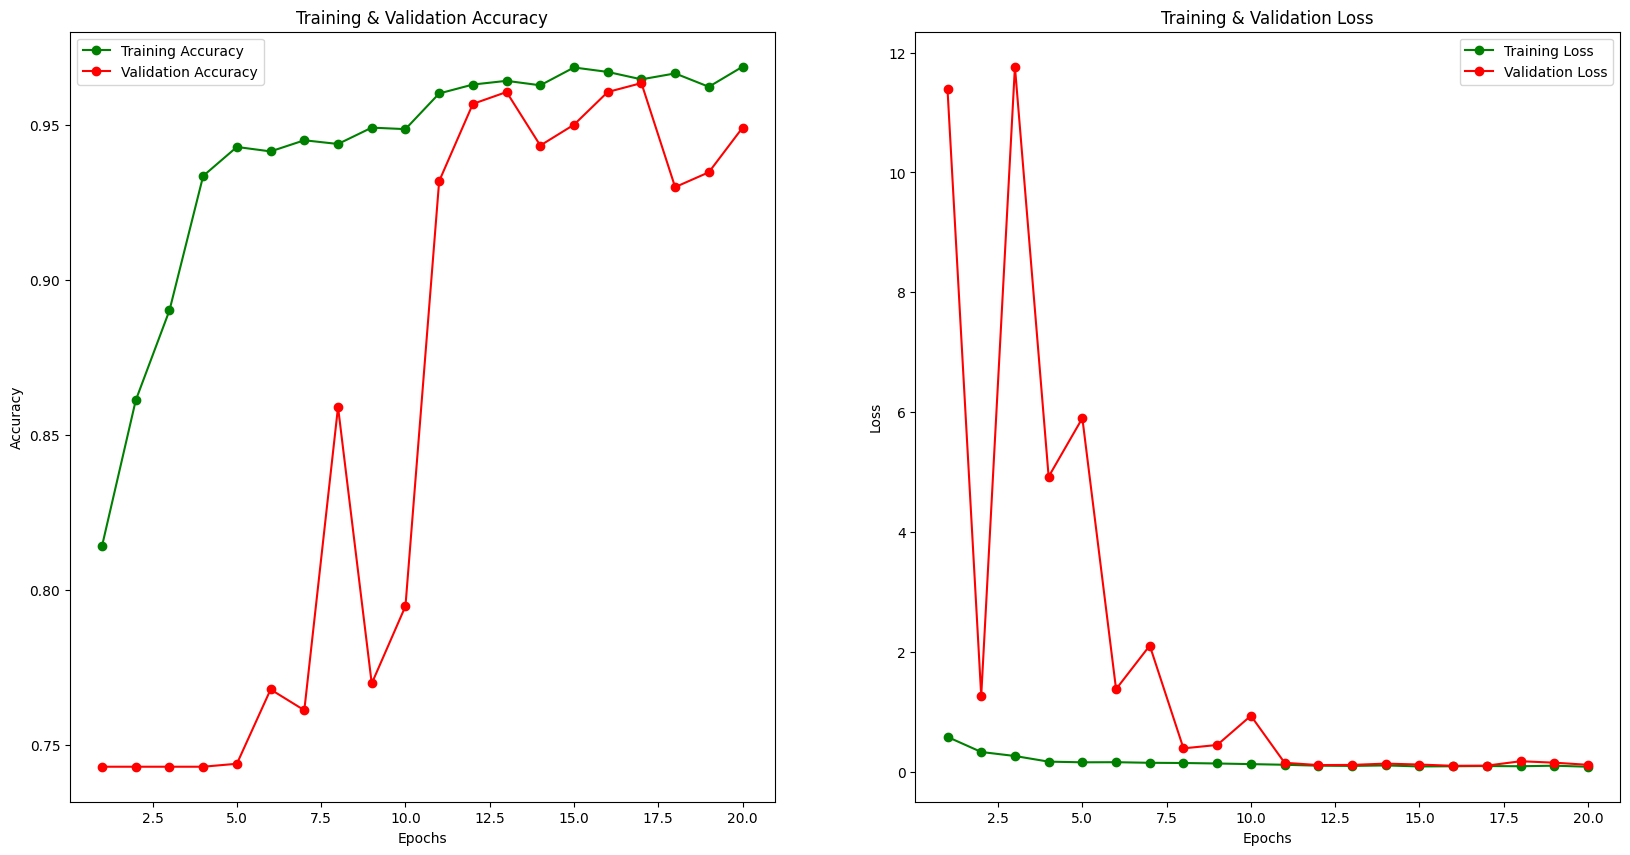

In [ ]:
"""import matplotlib.pyplot as plt

# 1. Get the lists of results from your history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# 2. Get the number of epochs that *actually ran*
num_epochs = len(train_acc)

# 3. Create the correct x-axis (e.g., [1, 2, 3, ...])
epochs_range = range(1, num_epochs + 1)

# 4. Create your plots
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

# --- Plot 1: Accuracy ---
ax[0].plot(epochs_range, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# --- Plot 2: Loss ---
ax[1].plot(epochs_range, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs_range, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show() """

In [ ]:
""" import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get the model's raw probability predictions from the generator
#    This will be a 2D array like [[0.98], [0.12], [0.75], ...]
predictions_raw = model.predict(test_gen)

# 2. Convert probabilities to class labels (0 or 1)
#    Your logic here is correct.
predictions = (predictions_raw > 0.5).astype('int32')

# 3. Flatten the 2D array [[1], [0], [1]] into a 1D array [1, 0, 1]
#    .reshape(-1) is a simpler way to do this.
predictions = predictions.reshape(-1)

# 4. Get the *true* labels from the generator
#    This works because we set shuffle=False on test_gen
true_labels = test_gen.classes

# 5. Now you can print your first 15 predictions
print(f"First 15 Predictions: {predictions[:15]}")
print(f"First 15 True Labels:   {true_labels[:15]}") """

163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 899ms/step
First 15 Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
First 15 True Labels:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Evaluation of predictions

In [ ]:
""" # 'true_labels' is the variable we created from test_gen.classes
# 'predictions' is the variable from model.predict()

# We must get the class names in the correct order (0, then 1)
# You can check this with print(test_gen.class_indices)
# It will show {'NORMAL': 0, 'PNEUMONIA': 1}
class_names = ['NORMAL', 'PNEUMONIA']

print(classification_report(true_labels, predictions, target_names=class_names)) """

              precision    recall  f1-score   support

      NORMAL       0.80      0.98      0.88      1341
   PNEUMONIA       0.99      0.91      0.95      3875

    accuracy                           0.93      5216
   macro avg       0.90      0.95      0.92      5216
weighted avg       0.94      0.93      0.93      5216



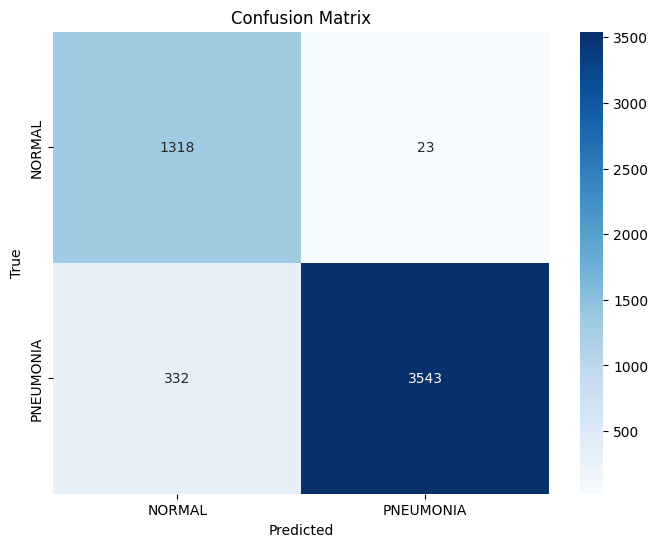

In [ ]:
"""import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# We assume 'true_labels' (from test_gen.classes) and 'predictions' (from model.predict)
# were created in the previous steps.

# 1. Get the class names in the correct order [0, 1]
#    Check with: print(test_gen.class_indices)
#    It should be {'NORMAL': 0, 'PNEUMONIA': 1}
class_names = ['NORMAL', 'PNEUMONIA']

# 2. Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# 3. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show() """

Correct predictions

163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 912ms/step


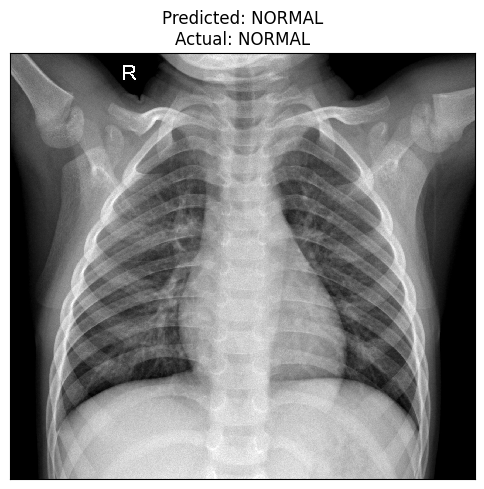

In [ ]:
"""import matplotlib.image as mpimg
filenames = test_gen.filenames
base_test_dir = test_gen.directory
class_names = list(test_gen.class_indices.keys())
true_labels = test_gen.classes

#Re-run predictions just in case (optional, but safe)
predictions_raw = model.predict(test_gen)
predictions = (predictions_raw > 0.5).astype('int32').reshape(-1)

# Find the indices of all correct predictions
correct_indices = np.nonzero(predictions == true_labels)[0]

# --- Plot one correct image ---

# 1. Get the index for a single correct image (e.g., the 10th one)
#    You can change '10' to any number, like 50, 100, etc.
c = correct_indices[10]

# 2. Get the filename and build the full path
img_path = filenames[c]
full_img_path = os.path.join(base_test_dir, img_path)

# 3. Read and show the image
img = mpimg.imread(full_img_path)

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])

# 4. Get the label names (e.g., "PNEUMONIA")
pred_label_name = class_names[predictions[c]]
true_label_name = class_names[true_labels[c]]

plt.title(f"Predicted: {pred_label_name}\nActual: {true_label_name}")
plt.show() """

In [ ]:
"""img = cv2.imread(full_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
img = cv2.resize(img, (150, 150))           # Resize to 150x150

# 2. Preprocess the image for the model
#    a. Normalize the pixels
img_array = np.array(img) / 255.0
#    b. Add the 'batch' and 'channel' dimensions
#       The shape becomes (1, 150, 150, 1)
img_array_expanded = np.expand_dims(img_array, axis=[0, -1])

print(f"Image shape ready for model: {img_array_expanded.shape}")



#That's perfect. The shape (1, 150, 150, 1) is exactly what the model needs to make a prediction:
#1: One image in the batch.

#150, 150: The image height and width.

#1: One grayscale channel.

#You are now ready to run the Step 3 code cell to generate the heatmap. """

Image shape ready for model: (1, 150, 150, 1)


In [ ]:
"""import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2

# --- Setup: Get all the necessary lists ---
print("Getting file lists and predictions...")
filenames = test_gen.filenames
base_test_dir = test_gen.directory
class_names = list(test_gen.class_indices.keys())
true_labels = test_gen.classes

# Re-run predictions to be safe
predictions_raw = model.predict(test_gen)
predictions = (predictions_raw > 0.5).astype('int32').reshape(-1)

# Find the indices of all correct predictions
correct_indices = np.nonzero(predictions == true_labels)[0]

# --- Pick one image to analyze ---
# You can change '10' to any number from your 'correct_indices'
image_index_to_analyze = correct_indices[10]
print(f"Analyzing image at index: {image_index_to_analyze}")

# 1. Get its path
img_path = filenames[image_index_to_analyze]
full_img_path = os.path.join(base_test_dir, img_path)

# 2. Load the image using cv2 (this is the original Step 2)
img = cv2.imread(full_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
img = cv2.resize(img, (150, 150))           # Resize to 150x150

# 3. Preprocess the image for the model
img_array = np.array(img) / 255.0
img_array_expanded = np.expand_dims(img_array, axis=[0, -1])

print(f"Image shape ready for model: {img_array_expanded.shape}") """

Getting file lists and predictions...
163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 922ms/step
Analyzing image at index: 10
Image shape ready for model: (1, 150, 150, 1)


## Grad cam on custom model

In [ ]:
#Grad cam
"""import tensorflow as tf
from keras.models import load_model, Model
from keras.layers import Conv2D
import matplotlib.cm as cm
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# We assume 'test_gen' is still in memory.
# If you get a NameError for 'test_gen', re-run your test_gen cell,
# then run this cell again.

try:
    print("--- Loading trained model from file... ---")
    # This is the key: we load the trained model from the file
    model = load_model("my_trained_model.h5")
    print("Model loaded successfully.")

    # --- XAI Step 1: Find Last Conv Layer ---
    print("Step 1: Finding Last Conv Layer...")
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            last_conv_layer = layer
            break
    print(f"Found the last Conv2D layer: {last_conv_layer.name}")

    # --- XAI Step 2: Load & Preprocess Image ---
    print("Step 2: Loading & Preprocessing Image...")
    filenames = test_gen.filenames
    base_test_dir = test_gen.directory
    class_names = list(test_gen.class_indices.keys())
    true_labels = test_gen.classes

    predictions_raw = model.predict(test_gen)
    predictions = (predictions_raw > 0.5).astype('int32').reshape(-1)

    correct_indices = np.nonzero(predictions == true_labels)[0]
    image_index_to_analyze = correct_indices[10] # Pick the 10th correct image

    img_path = filenames[image_index_to_analyze]
    full_img_path = os.path.join(base_test_dir, img_path)
    img = cv2.imread(full_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (150, 150))
    img_array = np.array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=[0, -1])
    print(f"Image shape ready for model: {img_array_expanded.shape}")

    # --- XAI Step 3: Generate Heatmap ---
    print("Step 3: Generating Heatmap...")
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array_expanded)
        class_channel = preds[0]

    grads = tape.gradient(class_channel, last_conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    heatmap = heatmap.numpy()
    print("Heatmap generated successfully.")

    # --- XAI Step 4: Plot the Result ---
    print("Step 4: Plotting Heatmap...")
    img_original = cv2.imread(full_img_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))

    heatmap_rgb = cm.jet(heatmap_resized)[..., :3]

    superimposed_img = heatmap_rgb * 0.4 + (img_original / 255.0)
    superimposed_img = np.clip(superimposed_img, 0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Heatmap\n(Red = Important for Prediction)")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"\n--- An Error Occurred ---")
    print(f"Error: {e}") """

In [13]:
#Grad Cam++
"""import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D
import matplotlib.cm as cm
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Function to apply Grad-CAM++
def apply_gradcam_plus_plus(model, img_array, last_conv_layer_name, pred_index=None):
    """
    Applies Grad-CAM++ to generate a heatmap.

    Args:
        model: The Keras model.
        img_array: The preprocessed image array (shape: (1, height, width, channels)).
        last_conv_layer_name: The name of the last convolutional layer in the model.
        pred_index: The index of the predicted class (optional). If None, the
                    argmax of the predictions is used.

    Returns:
        A heatmap (numpy array) of the same size as the last convolutional layer's output.
    """
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    first_derivations = grads
    second_derivations = tape.gradient(first_derivations, last_conv_layer_output)
    third_derivations = tape.gradient(second_derivations, last_conv_layer_output)

    global_sum = tf.reduce_sum(last_conv_layer_output, axis=(0, 1, 2))

    alpha_num = second_derivations
    alpha_den = second_derivations * 2.0 + third_derivations * global_sum
    alpha_den = tf.where(alpha_den == 0, 1e-10, alpha_den) # Avoid division by zero

    alphas = alpha_num / alpha_den
    alpha_normalization_constant = tf.reduce_sum(alphas, axis=(0, 1))
    alphas /= tf.where(alpha_normalization_constant == 0, 1e-10, alpha_normalization_constant) # Avoid division by zero

    weights = tf.maximum(grads, 0.0)

    deep_insights = weights * alphas
    deep_insights = tf.reduce_sum(deep_insights, axis=(0, 1))
    cam = tf.reduce_sum(deep_insights * last_conv_layer_output, axis=-1)

    heatmap = tf.maximum(cam, 0) / (tf.math.reduce_max(cam) + 1e-10)
    return heatmap.numpy()

# --- Main part of the script (similar to previous heatmap cell) ---

try:
    print("--- Loading trained model from file... ---")
    model = load_model("my_trained_model.h5")
    print("Model loaded successfully.")

    # --- Find Last Conv Layer ---
    print("Finding Last Conv Layer...")
    last_conv_layer = None
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            last_conv_layer = layer
            last_conv_layer_name = layer.name
            break
    if last_conv_layer_name is None:
        raise ValueError("Could not find a Conv2D layer in the model.")
    print(f"Found the last Conv2D layer: {last_conv_layer_name}")

    # --- Load & Preprocess Image ---
    print("Loading & Preprocessing Image...")
    # Assuming test_gen, filenames, base_test_dir, class_names, true_labels, predictions are available
    # from previous cells. If not, you may need to re-run those cells.
    filenames = test_gen.filenames
    base_test_dir = test_gen.directory
    class_names = list(test_gen.class_indices.keys())
    true_labels = test_gen.classes

    # Re-run predictions to be safe (or ensure 'predictions' is up-to-date)
    predictions_raw = model.predict(test_gen)
    predictions = (predictions_raw > 0.5).astype('int32').reshape(-1)

    # Find correct predictions
    correct_indices = np.nonzero(predictions == true_labels)[0]
    if len(correct_indices) == 0:
        print("No correct predictions found in the test set.")
    else:
        image_index_to_analyze = correct_indices[10] # Pick the 10th correct image
        print(f"Analyzing image at index: {image_index_to_analyze}")

        img_path = filenames[image_index_to_analyze]
        full_img_path = os.path.join(base_test_dir, img_path)
        img = cv2.imread(full_img_path)
        img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For display later

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (150, 150))
        img_array = np.array(img) / 255.0
        img_array_expanded = np.expand_dims(img_array, axis=[0, -1])
        print(f"Image shape ready for model: {img_array_expanded.shape}")

        # --- Generate Heatmap using Grad-CAM++ ---
        print("Generating Heatmap using Grad-CAM++...")
        # Get the predicted index for the chosen image
        predicted_class_index = predictions[image_index_to_analyze]

        heatmap = apply_gradcam_plus_plus(
            model,
            img_array_expanded,
            last_conv_layer_name,
            pred_index=predicted_class_index # Provide the predicted class index
        )
        print("Heatmap generated successfully.")

        # --- Plot the Result ---
        print("Plotting Heatmap...")

        heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))

        # Use a color map
        heatmap_rgb = cm.jet(heatmap_resized)[..., :3]

        # Superimpose the heatmap on the original image
        superimposed_img = heatmap_rgb * 0.4 + (img_display / 255.0)
        superimposed_img = np.clip(superimposed_img, 0, 1)

        # Get label names
        pred_label_name = class_names[predicted_class_index]
        true_label_name = class_names[true_labels[image_index_to_analyze]]

        plt.figure(figsize=(8, 8))
        plt.imshow(superimposed_img)
        plt.title(f"Grad-CAM++ Heatmap (Predicted: {pred_label_name}, Actual: {true_label_name})\n(Red = Important for Prediction)")
        plt.axis('off')
        plt.show()

except Exception as e:
    print(f"\n--- An Error Occurred ---")
    print(f"Error: {e}") """

--- Loading trained model from file... ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Model loaded successfully.
Finding Last Conv Layer...
Found the last Conv2D layer: conv2d_5
Loading & Preprocessing Image...
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 301ms/step
Analyzing image at index: 10
Image shape ready for model: (1, 150, 150, 1)
Generating Heatmap using Grad-CAM++...

--- An Error Occurred ---
Error: The layer sequential_1 has never been called and thus has no defined output.
